In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from pandas_profiling import ProfileReport


In [8]:
data_folder = Path("data")
figs_folder = Path("figs")

df = pd.read_csv(data_folder / "covid19_global_confirmed_cases.csv", parse_dates=["date"])

In [3]:
profile = ProfileReport(df)
profile.to_file("df-profile.html")

In [4]:
first_cases_df = df[df.confirmed_cases != 0].sort_values(by="date").drop_duplicates("country_region", keep="first")
first_cases_df["month"] = first_cases_df.date.apply(lambda d: d.month)
first_cases_df["month_name"] = first_cases_df.date.apply(lambda d: d.month_name())
first_cases_df["week"] = first_cases_df.date.apply(lambda d: d.week)
first_cases_df["week_name"] = first_cases_df.date.apply(lambda d: f"{d.month_name()} '{(d.day-1) // 7 + 1}")


In [5]:
def get_week_name_dict():
    df = pd.DataFrame() 
    df["date"] = pd.date_range(start='1/1/2020', end='31/12/2020')
    df["week"] = df.date.apply(lambda d: d.week)
    df["week_name"] = df.date.apply(lambda d: f"{d.month_name()} week {(d.day-1) // 7 + 1}")
    return dict(map(tuple, df[["week", "week_name"]].values.tolist()))

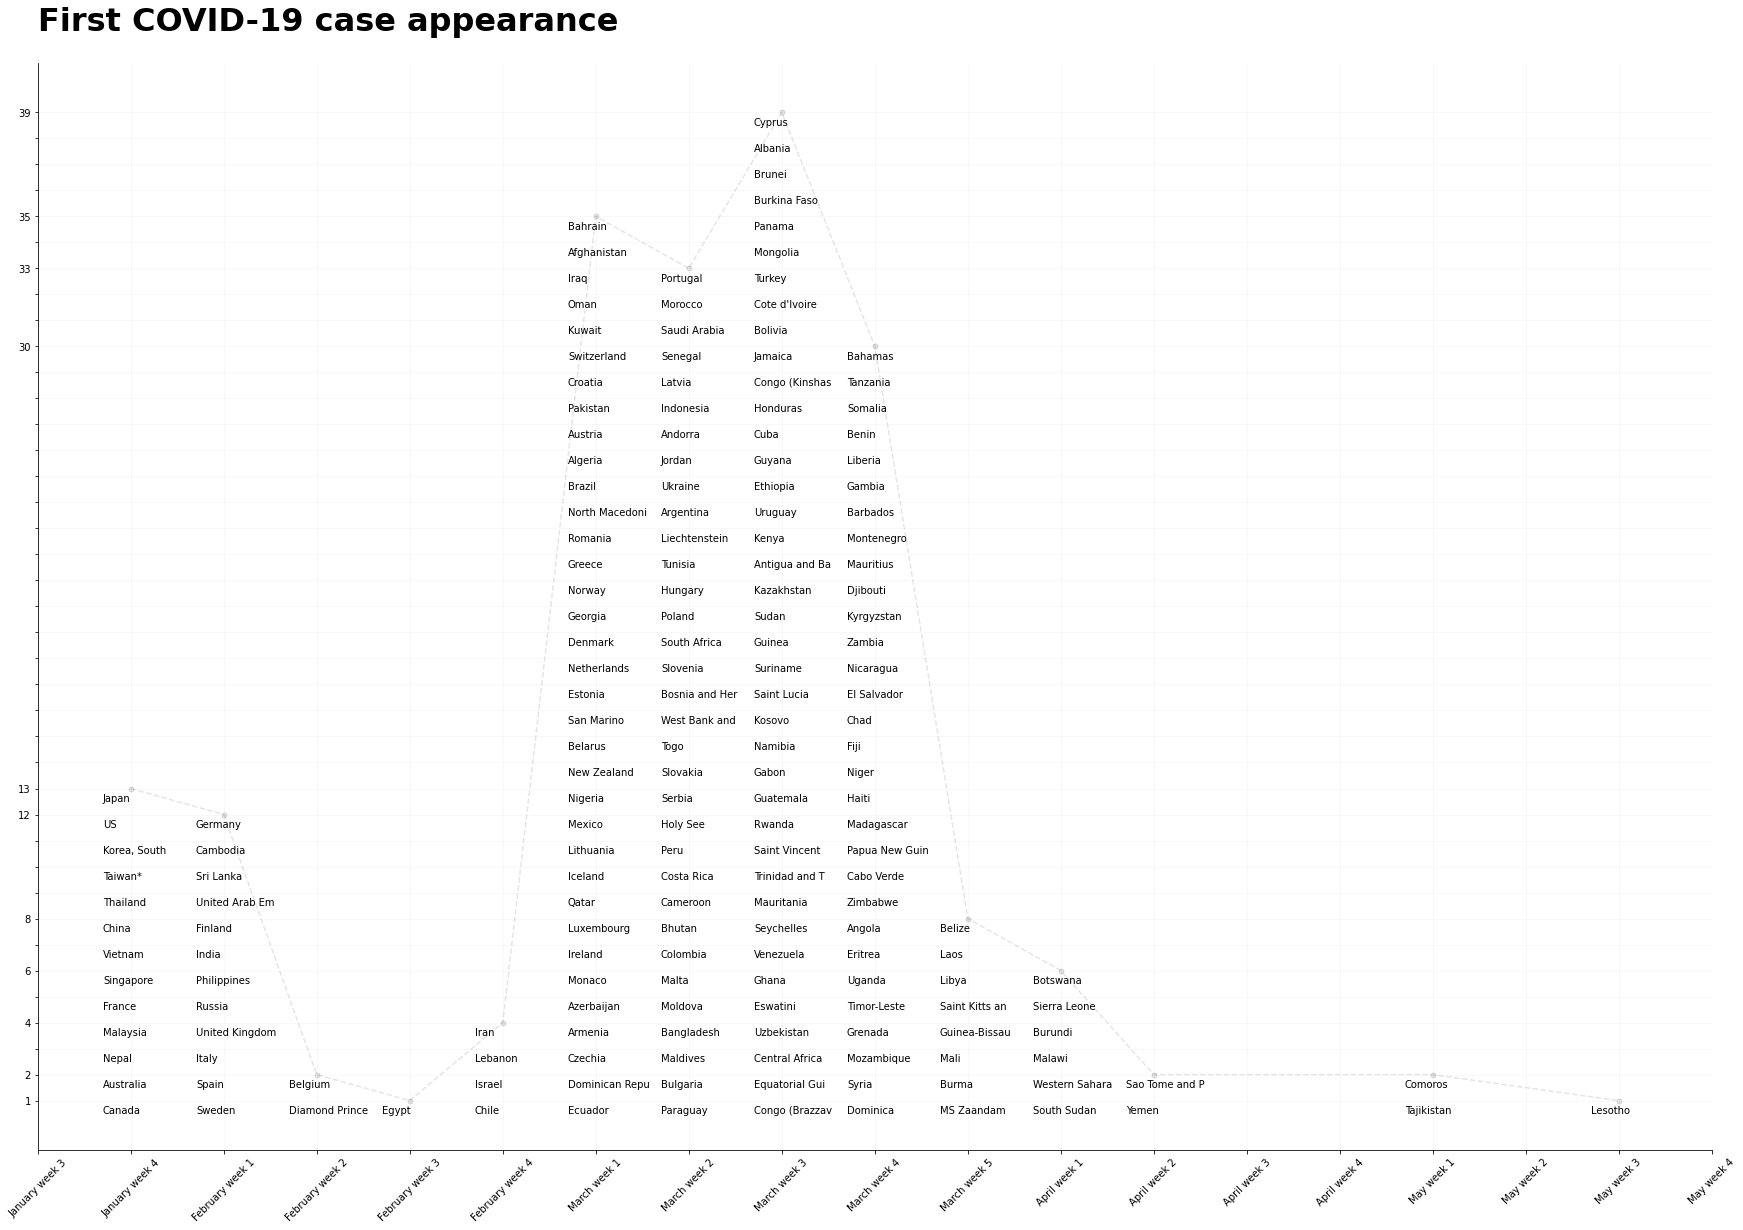

In [9]:
fig = plt.figure(figsize=(30, 20))
ax = plt.gca()

dots = []
mentioned_y = []

x_shift = 0.3
y_shift = 0.02
y_scaler = 0.04

max_county_len = 14
week_name_dict = get_week_name_dict()


# Plot bars
for month_id, month_df in first_cases_df.groupby("week"):
    min_date = month_df.date.min()
    month_df = month_df.sort_values(by="date")
    counties = month_df.country_region.tolist()
    
    for idx, country in enumerate(reversed(counties)):
        ax.text(
            month_id-x_shift,
            idx*y_scaler - y_shift,
            country[:max_county_len]
        )
    dots.append((month_id, idx*y_scaler))
    mentioned_y.append(idx+1)

    
# Plot dash line  
ax.plot(
    [d[0] for d in dots],
    [d[1] for d in dots],
    ".--",
    color="black", alpha=0.1, markersize=10
)


# Setup axes 
y_range = np.arange(0, max([d[1] for d in dots])+y_scaler, y_scaler)
y_labels = [l if (l := round(v / y_scaler) + 1) in set(mentioned_y) else  "" for v in y_range]
plt.yticks(
    ticks=y_range, 
    labels=y_labels
)

x_start = first_cases_df.week.min() - 1
x_end = first_cases_df.week.max()
x_range = list(range(x_start, x_end + 2))
plt.xlim(x_start, x_end)
plt.xticks(
    ticks=x_range, 
    labels=[week_name_dict[v] for v in x_range],
    rotation=45,
)

plt.title(
    "First COVID-19 case appearance", 
    fontdict={"fontsize": 32, "fontweight": "bold"},  
    loc="left", pad=32
)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.grid(alpha=0.1)
plt.savefig(figs_folder / "string-hist", bbox_inches="tight")

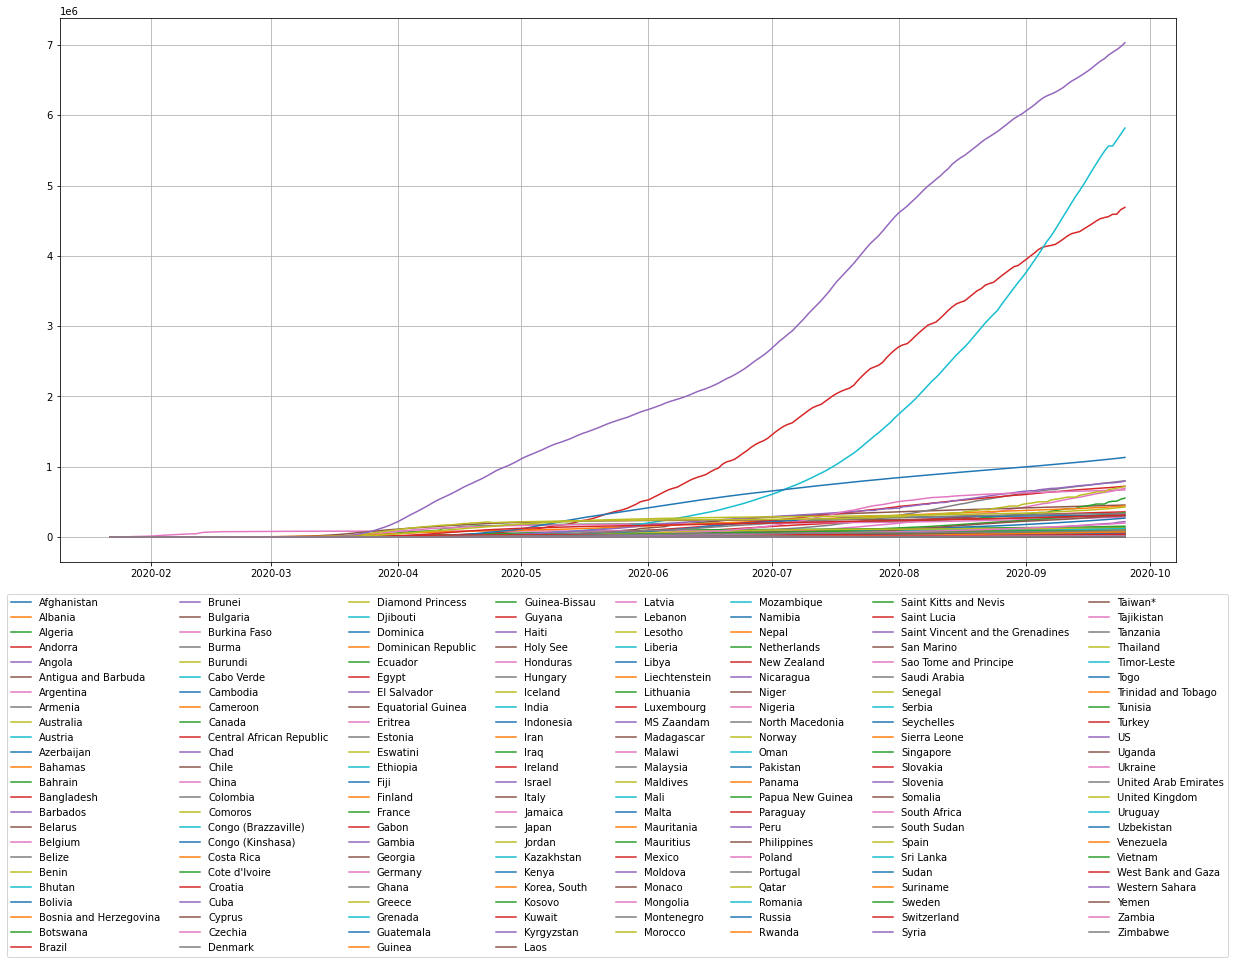

In [7]:
plt.figure(figsize=(20, 10))

for cntr_name, cntr_df in df.groupby("country_region"):
    plt.plot(cntr_df.date, cntr_df.confirmed_cases, label=cntr_name)
    
# plt.yscale("log2")
plt.grid()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=8)